# Proiect PAIC: A New Adaptive Switching Median Filter (ASWM)<hr/>Bulai Radu-Alexandru (411-TAID, ETTI UPB)

## Cuprins

## Citirea si afisarea imaginilor
Pentru ca rezultatele testelor să fie cât mai concludente, s-au ales 6 imagini color a căror rezoluție a fost modificată (`512x512` px) pentru a corespunde cu celelalte citite.

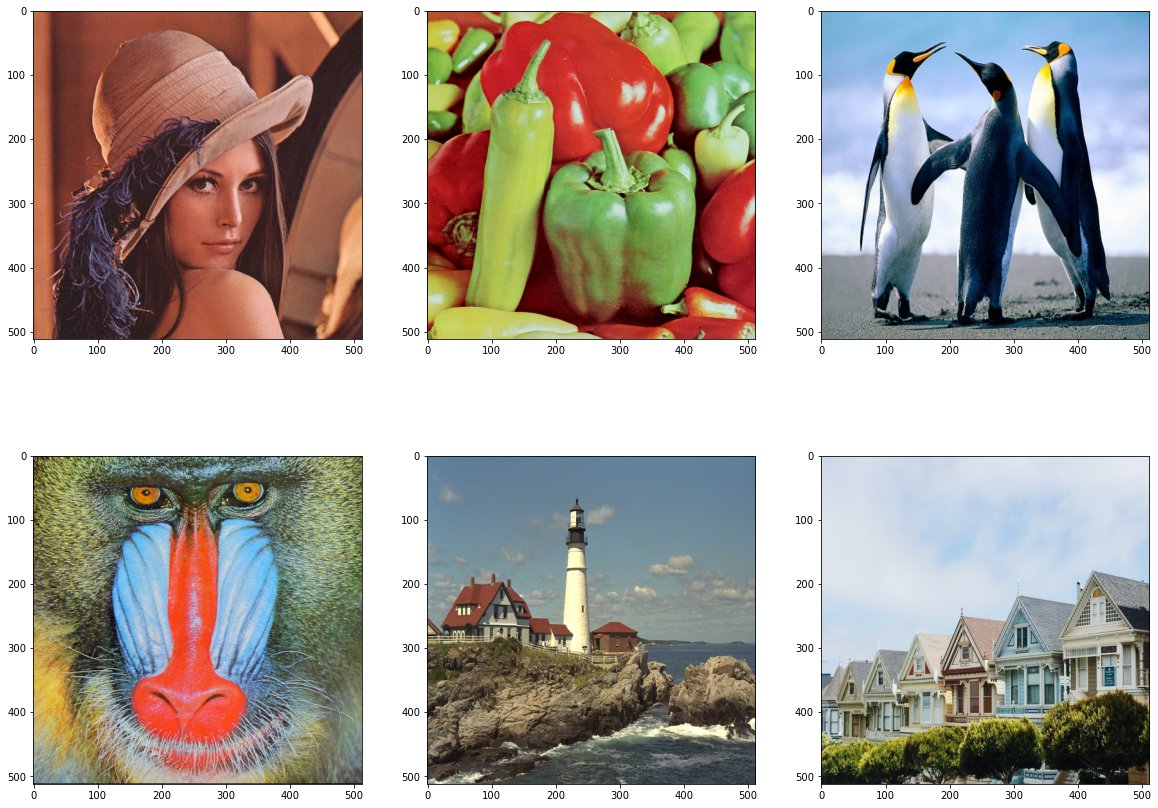

In [21]:
from skimage import io, color, measure
import matplotlib.pyplot as plt
import numpy as np

dir_path = './images/'
img_names = ['lena_color_512.bmp', 'peppers_512.png', 'penguins_512.jpg',
             'baboon_512.png', 'lighthouse_512.bmp', 'houses_512.jpg']

img_paths = [dir_path + _ for _ in img_names]

fig = plt.figure(figsize=(20, 15))
for i in range(0, len(img_paths)):
    img = io.imread(img_paths[i])
    fig.add_subplot(2,3,i+1); plt.imshow(img)

## Definirea functiei de zgomot impulsiv (sare si piper) si aplicarea acesteia pe imagini

In [22]:
def sp_noise(img_orig, ratio = 0.1):
    img = img_orig.copy()
    l, c, ch = img.shape
    length = int(l * c * ratio)
    lin = np.random.randint(0, l, [length])
    col = np.random.randint(0, c, [length])
    up_down = np.random.randint(0, 2, [length])
    for i in range(length):
        img[lin[i], col[i], np.random.randint(0, 3)] = 255 * up_down[i]
    return img

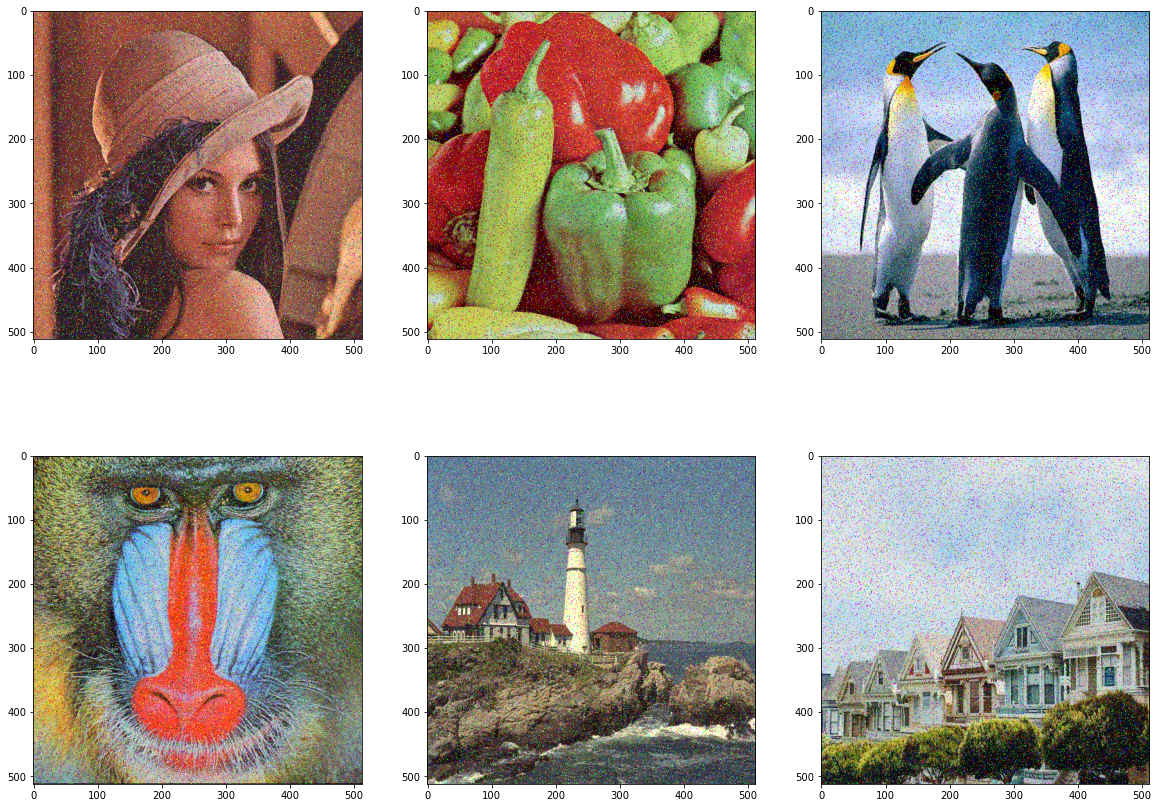

In [23]:
prob = 0.3

fig = plt.figure(figsize=(20, 15))
for i in range(0, len(img_paths)):
    img = io.imread(img_paths[i])
    img_noise = sp_noise(img, prob)
    fig.add_subplot(2,3,i+1); plt.imshow(img_noise)

## Implementarea filtrelor median clasic si SWM (Switching Median Filter)

### Filtrul median clasic

In [78]:
def median_filter(img):
    img_out = img.copy()
    
    l, c, ch = img_out.shape
    for k in range(ch):
        for i in range(1, l - 2):
            for j in range(1, c - 2):
                V = np.sort(img[i-1:i+2, j-1:j+2, k], axis = None)
                img_out[i, j, k] = V[4]
                
    return img_out.astype(np.uint8)

### Filtrul median "comutativ" (Switching Median Filter - SWM)
Filtrul SWM este mai eficient în eliminarea zgomotului de impuls și păstrarea caracteristicilor imaginii. Filtrul înlocuiește un pixel deteriorat de valoarea mediană sau de valoarea procesată a pixelului învecinat. Pixelii necorupți sunt lăsați nemodificați[2].

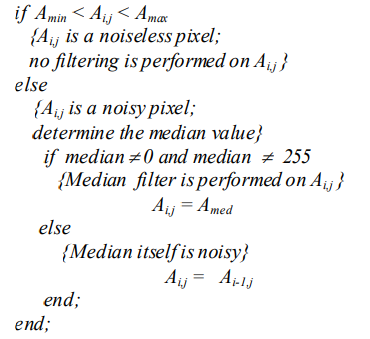

unde, $A_{ij}$ este intensitatea pixelului central din fereastra de filtrare, $A_min$, $A_max$ și $A_med$ sunt valoarea minimă, maximă și medie a pixelilor din fereastra de filtrare a imaginii zgomotoase. $A_{i-1, j}$ este intensitatea pixelului imediat vecin, deja procesat.

[2] *Pushpavalli, R., and G. Sivaradje. "Switching median filter for Image Enhancement." International Journal of Scientific & Engineering Research 3.2 (2012): 1-5.
Sursa: https://www.ijser.org/researchpaper/switching-median-filter-for-image-enhancement.pdf*

In [79]:
def swm_filter(img):
    img_out = img.copy()
    
    l, c, ch = img_out.shape
    for k in range(ch):
        for i in range(1, l - 2):
            for j in range(1, c - 2):    
                V = np.sort(img[i-1:i+2, j-1:j+2, k], axis = None)
                V_min, V_max = V[0], V[-1]
                
                if V_min < img_out[i, j, k] < V_max:
                    pass # no filtering needed
                else:
                    median = V[4]
                    if median != V_min and median != V_max:
                        img_out[i, j, k] = V[4]
                    else:
                        img_out[i, j, k] = img_out[i-1, j, k]
                
    return img_out.astype(np.uint8)

### Aplicarea filtrelor clasic median si SWM pe o imagine

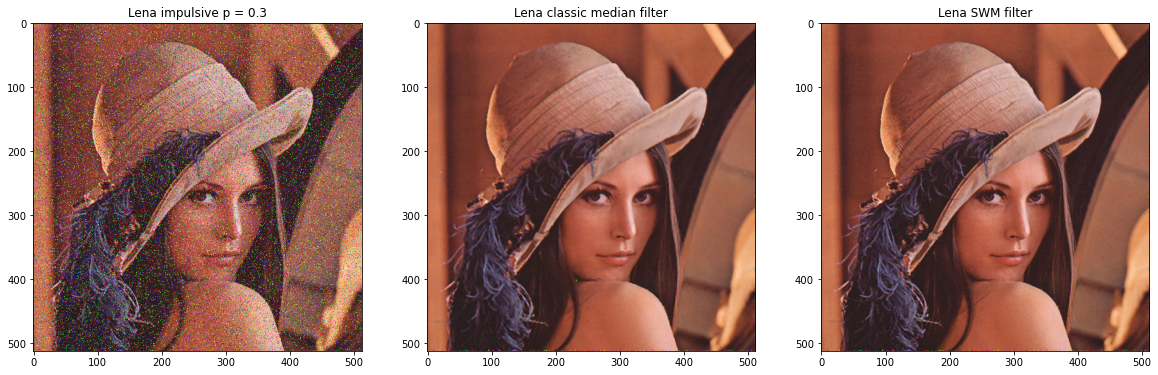

In [80]:
path = './images/'
img_path = path+'lena_color_512.bmp'

prob = 0.3

img = io.imread(img_path)
img_noise = sp_noise(img, prob)

img_median = median_filter(img_noise)
img_swm = swm_filter(img_noise)

fig = plt.figure(figsize=(20, 15))
fig.add_subplot(1,3,1).set_title(f'Lena impulsive p = {prob}'); plt.imshow(img_noise)
fig.add_subplot(1,3,2).set_title('Lena classic median filter'); plt.imshow(img_median)
fig.add_subplot(1,3,3).set_title('Lena SWM filter'); plt.imshow(img_swm)

## Implementarea filtrului ASWM (din articol)

Filtrul ASWM nu necesită un prag a priori ca în cazul unui filtru clasic de mediere comutativ. În schimb, pragul este calculat local din valorile intensității pixelilor imaginii într-o fereastră glisantă. Rezultatele arată că ASWM oferă o performanță mai bună în termeni de PSNR și MAE decât multe alte variante de filtru median pentru zgomotul impulsului evaluat aleatoriu. În plus, poate păstra mai multe detalii de imagine într-un mediu cu zgomot ridicat.

Pentru filtrul ASWM, valoarea medie ponderată și deviația standard ponderată sunt estimate în fereastra curentă. Greutățile sunt inversul distanței dintre valoarea medie ponderată a pixelilor dintr-o fereastră dată și pixelul considerat. Ca rezultat, zgomotul impulsiv nu corupe determinarea acestor statistici din care se derivă pragul.

În fiecare fereastră, media ponderată este mai întâi estimată iterativ. Apoi se calculează abaterea standard ponderată și se determină pragul.



In [130]:
def ASWM_filter(img, delta = 0.1, error = 0.01):
    img_out = img.copy()
    l, c, ch = img_out.shape
    
    for k in range(ch):
        for i in range(1, l - 2):
            for j in range(1, c - 2):
                alpha = 20
                window = img[i-1:i+2, j-1:j+2, k]
                
                # Initialization
                weights = np.array([[[1] * 3] * 3])
                windowMean = np.sum(np.multiply(weights, window)) / np.sum(weights)
                    
                while True:
                    windowMeanOld = windowMean
                    
                    # Step 1: Estimate the weights
                    weights = 1 / (np.abs((window - windowMean)) + delta)
                    windowMean = np.sum(np.multiply(weights, window)) / np.sum(weights)
                    
                    # Step 2 condtion
                    if np.abs(windowMean - windowMeanOld) < error:
                        break
                    alpha *= 0.8
                
                windowStdDeviation = np.sqrt(np.sum(np.multiply(weights, (window - windowMean)**2)) / np.sum(weights))
                
                if np.abs(img_out[i, j, k] - windowMean) > (alpha * windowStdDeviation):
                    img_out[i, j, k] = np.sort(window, axis = None)[4]
                else:
                    img_out[i, j, k] = img_out[i, j, k]
                
    return img_out.astype(np.uint8)

Testare filtru ASWM pe o imagine de dimensiune mică (`64 x 64`) / Debug

In [137]:
from datetime import datetime
tic = datetime.now()

path = './images/'
img_path = path+'lena_color_64.bmp'

img = io.imread(img_path)
img_noise = sp_noise(img, 0.3)

ASWM_filter(img_noise)
print(f'Duration: {datetime.now() - tic}')

Duration: 0:00:04.789234


### Aplicarea filtrului ASWM pe o imagine

Duration: 0:04:53.220245


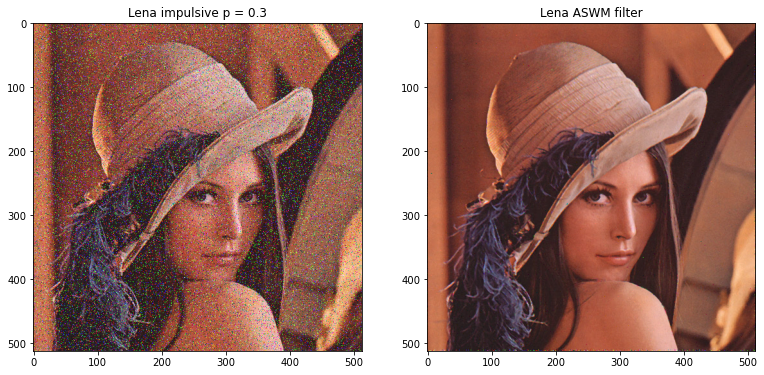

In [136]:
from datetime import datetime
tic = datetime.now()

path = './images/'
img_path = path+'lena_color_512.bmp'

prob = 0.3

img = io.imread(img_path)
img_noise = sp_noise(img, prob)

img_ASWM = ASWM_filter(img_noise)

fig = plt.figure(figsize=(20, 15))
fig.add_subplot(1,3,1).set_title(f'Lena impulsive p = {prob}'); plt.imshow(img_noise)
fig.add_subplot(1,3,2).set_title('Lena ASWM filter'); plt.imshow(img_ASWM)

print(f'Duration: {datetime.now() - tic}')

## Functii pentru masurarea zgomotului (PSNR, MAE)

In [138]:
def mse(imgInit, imgFinal): 
    r = np.asarray(imgInit, dtype=np.float64).ravel()
    c = np.asarray(imgFinal, dtype=np.float64).ravel()
    return np.mean(np.abs(r - c)**2)

def PSNR(imgInit, imgFinal):
    rng = imgInit.max() - imgFinal.min()
    dv = (rng + 0.0)**2
    with np.errstate(divide='ignore'):
        rt = dv / mse(imgInit, imgFinal)
    return 10.0 * np.log10(rt)

def MAE(imgInit, imgFinal):  
    r = np.asarray(imgInit, dtype=np.float64).ravel()
    c = np.asarray(imgFinal, dtype=np.float64).ravel()
    return np.mean(np.abs(r - c))

## Compararea celor 3 filtre

## Bibliografie
[1] *Akkoul, Smaïl, et al. "A new adaptive switching median filter." IEEE Signal Processing Letters 17.6 (2010): 587-590.<br/>
Link: https://ieeexplore.ieee.org/abstract/document/5451149*

[2] *Pushpavalli, R., and G. Sivaradje. "Switching median filter for Image Enhancement." International Journal of Scientific & Engineering Research 3.2 (2012): 1-5.<br/>
Link: https://www.ijser.org/researchpaper/switching-median-filter-for-image-enhancement.pdf*